In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn, optim

## Generate training data

Generate sine waves with a random initial phase, plus a random uniform noise. 

In [2]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4096)
        ys = np.sin(xs) + np.random.rand(4096)*0.2-0.1
#         ys = np.sin(xs)
        ys = ys.astype(np.float32) # default is np.float64
        x = torch.from_numpy(ys[:4000]).view(1,1,-1)
        y = torch.from_numpy(ys[1024:4001]).view(1,1,-1)
        yield Variable(x), Variable(y)

g = batch_generator()

## Visualize a mini-batch

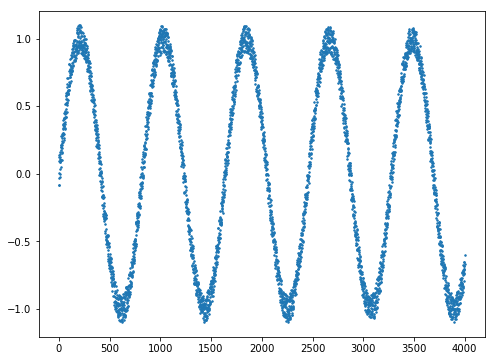

In [3]:
x, _ = next(g)
plt.figure(figsize=[8,6])
plt.plot(x.data.numpy()[0][0],'.', ms=3)

## Network model

Everything is linear. Nonlinear activation functions are important when there are noises in the input data.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
        self.main = nn.Sequential()
        for i,d in enumerate(dilations):
            self.main.add_module(str(i),nn.Conv1d(in_channels=1,out_channels=1, kernel_size=2,dilation=d))
            self.main.add_module(str(i)+'.elu', nn.ELU())
    def forward(self, input):
        return self.main(input)

## Network training

In [5]:
net = Net()

max_epoch = 4000
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_save = []
g = batch_generator()
for epoch in range(max_epoch):
    x, y = next(g)
    optimizer.zero_grad()
    y_hat = net(x)
    loss = ((y_hat-y)**2).mean()
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    if epoch%100==0:
        print('epoch {}, loss {:8.4g}'.format(epoch, loss.data[0]))
    

epoch 0, loss   0.7053
epoch 100, loss   0.5144
epoch 200, loss   0.5126
epoch 300, loss   0.5083
epoch 400, loss   0.3587
epoch 500, loss  0.08025
epoch 600, loss  0.02944
epoch 700, loss  0.02162
epoch 800, loss  0.01764
epoch 900, loss  0.01522
epoch 1000, loss  0.01391
epoch 1100, loss  0.01283
epoch 1200, loss  0.01202
epoch 1300, loss  0.01142
epoch 1400, loss  0.01124
epoch 1500, loss  0.01124
epoch 1600, loss  0.01069
epoch 1700, loss  0.01032
epoch 1800, loss  0.01046
epoch 1900, loss 0.009747
epoch 2000, loss 0.009898
epoch 2100, loss 0.009981
epoch 2200, loss 0.009968
epoch 2300, loss 0.009672
epoch 2400, loss  0.00923
epoch 2500, loss 0.009326
epoch 2600, loss 0.009558
epoch 2700, loss 0.008924
epoch 2800, loss 0.008972
epoch 2900, loss  0.00895
epoch 3000, loss 0.008702
epoch 3100, loss 0.008923
epoch 3200, loss 0.008649
epoch 3300, loss 0.008816
epoch 3400, loss 0.008769
epoch 3500, loss 0.008834
epoch 3600, loss 0.008451
epoch 3700, loss 0.008298
epoch 3800, loss 0.00854

## Loss during training

(10, 4000)

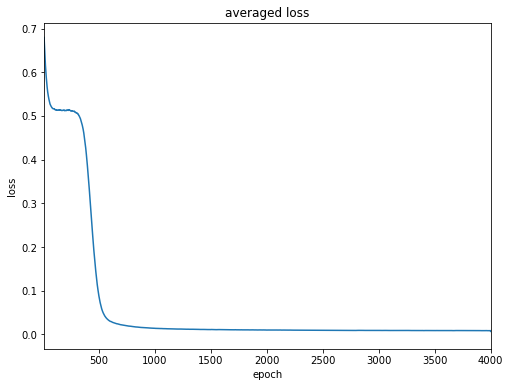

In [6]:
plt.figure(figsize=[8,6])
plt.plot(np.convolve(loss_save, np.ones(10)/10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('averaged loss')
plt.xlim([10,4000])

## Evaluate model

### seeding with a training mini-batch

In [7]:
x, _ = next(g)
x = x.data.numpy()
n = 10000

predict_save = []
for _ in range(n):
    x_var = Variable(torch.from_numpy(x))
    predict = net(x_var)
    predict_save.append(predict.data[0][0][-1])
    x = np.roll(x,-1,axis=2)
    x[0][0][-1] = predict.data[0][0][-1]

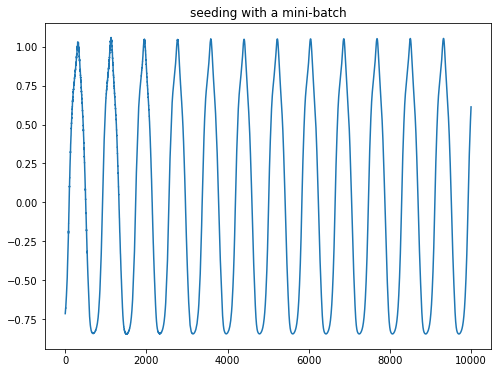

In [8]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.title('seeding with a mini-batch')
# plt.ylim([-1,1])

### seeding with random numbers

In [17]:
x = np.random.rand(1,1,1024).astype(np.float32)
n = 10000

predict_save = []
for _ in range(n):
    x_var = Variable(torch.from_numpy(x))
    predict = net(x_var)
    predict_save.append(predict.data[0][0][-1])
    x = np.roll(x,-1,axis=2)
    x[0][0][-1] = predict.data[0][0][-1]

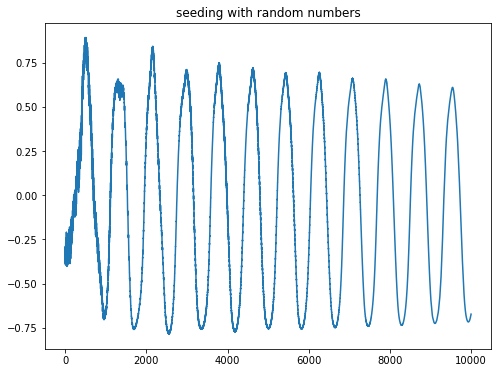

In [18]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.title('seeding with random numbers')

## Visualize each dilation conv layer

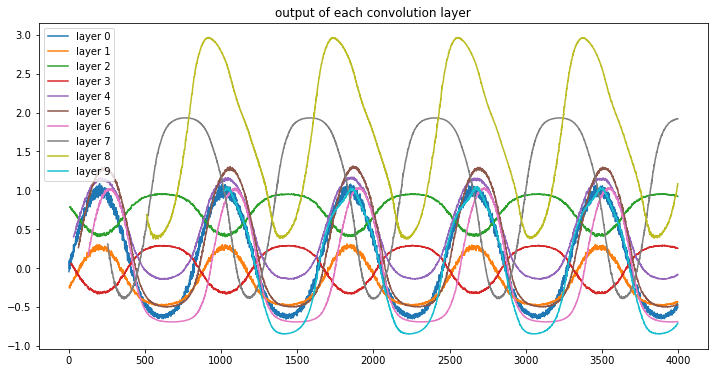

In [14]:
x, _ = next(g)
sz = x.size(-1)

plt.figure(figsize=[12,6])
layer_labels = []
for i in range(0,20,2):
    m = net.main[i]
    x = m(x)
    x = net.main[i+1](x)
    sz_x = x.size(-1)
    plt.plot(range(sz-sz_x,sz),x.data.numpy()[0][0])
    layer_labels.append('layer {}'.format(i//2))
plt.title('output of each convolution layer')
plt.legend(layer_labels)